In [853]:
def metric_TTM(metric):
    
    return metric[::-1].rolling(4).sum()[::-1]


def percent_change(values):

    values = list(values)

    changes = [
        round((values[i] - values[i+4]) / abs(values[i+4]) * 100, 2)
        if ((values[i]) and (values[i] != 0) and (values[i+4]) and (values[i+4] != 0))
        else np.nan
        for i
        in range(len(values) - 4)
    ]
    while len(changes) < len(values):
        changes.append(np.nan)
    return changes

In [945]:
def stock_summary_data(ticker):
    
    metrics = get_metrics(ticker)
    metrics_daily = get_daily_metrics(ticker, metrics)
    averages = historical_averages(metrics_daily)
    
    stats = get_stats(metrics_daily, averages)
    
    return metrics, metrics_daily, stats

In [952]:
METRICS = ['revenue', 'grossProfit', 'operatingIncome', 'ebitda', 'netIncome']


def get_metrics(ticker):
    
    df = pd.DataFrame(requests.get(f"{base_url}/income-statement/{ticker}?period=quarter&apikey={KEY}").json())

    df['quarter'] = df.apply(lambda x: x['calendarYear'] + ' ' + x['period'], axis=1)
    
    for metric in METRICS:
        df[metric + 'TTM'] = metric_TTM(df[metric])
        df[metric + 'GrowthTTM'] = percent_change(df[metric + 'TTM'])
        
    df['grossMarginTTM'] = (df['grossProfitTTM'] / df['revenueTTM'] * 100).round(2)
    df['operatingMarginTTM'] = (df['operatingIncomeTTM'] / df['revenueTTM'] * 100).round(2)
    df['ebitdaMarginTTM'] = (df['ebitdaTTM'] / df['revenueTTM'] * 100).round(2)
    df['profitMarginTTM'] = (df['netIncomeTTM'] / df['revenueTTM'] * 100).round(2)
    
    return df


In [1056]:
def get_daily_metrics(ticker, metrics):
    
    market_cap = requests.get(f"{base_url}/historical-market-capitalization/{ticker}?apikey={KEY}").json()
    market_cap = pd.DataFrame(market_cap)[['date', 'marketCap']]
    
    df = pd.merge(market_cap, metrics, on='date', how='outer')
    
    df = df.sort_values('date', ascending=False)
    
    for metric in METRICS:
        df[metric + 'TTM'] = df[metric + 'TTM'].fillna(method='ffill')
        df[metric + 'TTM'] = df[metric + 'TTM'].fillna(method='bfill')

        df[metric + 'GrowthTTM'] = df[metric + 'GrowthTTM'].fillna(method='ffill')
        df[metric + 'GrowthTTM'] = df[metric + 'GrowthTTM'].fillna(method='bfill')

    for metric in ['grossMarginTTM', 'operatingMarginTTM', 'profitMarginTTM', 'quarter']:
        df[metric] = df[metric].fillna(method='ffill')
        df[metric] = df[metric].fillna(method='bfill')
        
        
    # Calculate ratios
    df['priceToGrossProfitRatio'] = df['marketCap'] / df['grossProfitTTM']    
    df['priceToOperatingIncomeRatio'] = df['marketCap'] / df['operatingIncomeTTM']
    df['priceToebitdaRatio'] = df['marketCap'] / df['ebitdaTTM']
    df['priceToNetIncomeRatio'] = df['marketCap'] / df['netIncomeTTM']
    
    df['priceToGrossProfitGrowthRatio'] = df['priceToGrossProfitRatio'] / df['grossProfitGrowthTTM']
    
    return df

In [1057]:
def historical_averages(df):
    
    averages = {}
    
    for metric in STATS_RATIOS:
        averages[metric + '_1y_mean'] = df[df['date'] > one_year_ago][metric].mean()
        averages[metric + '_2y_mean'] = df[df['date'] > two_years_ago][metric].mean()
    
    return averages

In [1058]:
STATS_METRICS = [
    'grossProfitGrowthTTM', 'operatingIncomeGrowthTTM', 'ebitdaGrowthTTM', 'netIncomeGrowthTTM'
]
STATS_RATIOS = [
    'priceToGrossProfitRatio', 'priceToGrossProfitGrowthRatio', 'priceToOperatingIncomeRatio',
    'priceToebitdaRatio', 'priceToNetIncomeRatio',
    'grossMarginTTM', 'operatingMarginTTM', 'ebitdaMarginTTM', 'profitMarginTTM'
]

def get_stats(metrics_daily, averages):
    
    stats = {}
    
    for metric in STATS_METRICS:
        stats[metric] = {
            'current': round(metrics_daily[metric], 2)[0],
            'previous_1Y': round(list(metrics_daily[metrics_daily['date'] < one_year_ago][metric])[0], 2),
            'previous_2Y': round(list(metrics_daily[metrics_daily['date'] < two_years_ago][metric])[0], 2),
#             'forecast': float(estimates.loc[estimates['Symbol'] == ticker, 'Gross Profit Growth (FY2)'])
        }
        
    for metric in STATS_RATIOS:
        stats[metric] = {
            'current': round(metrics_daily[metric], 2)[0],
            'average_1Y': round(averages[metric + '_1y_mean'], 2),
            'average_2Y': round(averages[metric + '_2y_mean'], 2),
#             'forecast': float(estimates.loc[estimates['Symbol'] == ticker, 'priceToGrossProfitRatio_FY2'])
        }
    
    return stats

In [1356]:
def market_stats(stats):
    
    ticker = list(stats)[0]
    metrics = list(stats[ticker])
    submetrics = list(stats)
    
    stats_market = {}

    for metric in metrics:

        stats_market[metric] = {}

        for submetric in stats[ticker][metric]:

            stats_market[metric][submetric] = np.median([
                stats[ticker][metric][submetric]
                for ticker
                in list(stats)[:-1]
                if str(stats[ticker][metric][submetric]) != "nan"
            ])
            
    return stats_market

In [1354]:
def summary_stats(stats):
    
    summary = pd.DataFrame()
    summary['tickers'] = list(stats)

    # summary['priceToGrossProfitGrowthRatio_forecast'] = get_metric_stats(stats, 'priceToGrossProfitGrowthRatio', 'forecast')
    summary['priceToGrossProfitGrowthRatio_current'] = get_metric_stats(stats, 'priceToGrossProfitGrowthRatio', 'current')

    summary['grossProfitGrowthTTM_current'] = get_metric_stats(stats, 'grossProfitGrowthTTM', 'current')
    # summary['grossProfitGrowthTTM_forecast'] = get_metric_stats(stats, 'grossProfitGrowthTTM', 'forecast')

    summary['priceToGrossProfitRatio_current'] = get_metric_stats(stats, 'priceToGrossProfitRatio', 'current')

    summary['grossMargin_current'] = get_metric_stats(stats, 'grossMarginTTM', 'current')
    summary['operatingMargin_current'] = get_metric_stats(stats, 'operatingMarginTTM', 'current')
    summary['operatingMargin_previous_1Y'] = get_metric_stats(stats, 'operatingMarginTTM', 'average_1Y')
    summary['ebitdaMargin_current'] = get_metric_stats(stats, 'ebitdaMarginTTM', 'current')
    summary['ebitdaMargin_previous_1Y'] = get_metric_stats(stats, 'ebitdaMarginTTM', 'average_1Y')
    summary['profitMargin_current'] = get_metric_stats(stats, 'profitMarginTTM', 'current')
    summary['profitMargin_previous_1Y'] = get_metric_stats(stats, 'profitMarginTTM', 'average_1Y')

    return summary


def get_metric_stats(stats, metric, period):
    
    return [stats[ticker][metric][period] for ticker in list(stats)]


In [1318]:
def metrics_market(df, period):
    
    daily_aggregation = {
        'revenueGrowthTTM': 'median',
        'grossProfitGrowthTTM': 'median',

        'grossMarginTTM': 'median',
        'operatingMarginTTM': 'median',
        'profitMarginTTM': 'median',
        
        'priceToGrossProfitRatio': 'median',
        'priceToOperatingIncomeRatio': 'median',
        'priceToebitdaRatio': 'median',
        'priceToNetIncomeRatio': 'median',
        'priceToGrossProfitGrowthRatio': 'median'
    }
    quarter_aggregation = {
        'revenueGrowthTTM': 'median',
        'grossProfitGrowthTTM': 'median',

        'grossMarginTTM': 'median',
        'operatingMarginTTM': 'median',
        'profitMarginTTM': 'median',
    }
    
    df_concat = pd.concat([df[ticker] for ticker in list(df) if ticker != "market"])
    
    if period == "date":
        df['market'] = df_concat.groupby(period).agg(daily_aggregation)[::-1].reset_index()
    
    else:
        df['market'] = df_concat.groupby(period).agg(quarter_aggregation)[::-1].reset_index()
    
    return df['market']

In [628]:
def estimate_data():
    
    estimates = pd.read_csv("/Users/davidcurie/Downloads/AtomCompsData_My Stocks (11).csv")

    estimates['Market Cap'] = estimates['Market Cap'].str.replace('[$,]', '').astype(float)
    estimates['Gross Profit (FY2)'] = estimates['Gross Profit (FY2)'].str.replace('[$,]', '').astype(float)
    estimates['Gross Profit Growth (FY2)'] = estimates['Gross Profit Growth (FY2)'].str.replace('%', '').astype(float)

    estimates['priceToGrossProfitRatio_FY2'] = round(estimates['Market Cap'] / estimates['Gross Profit (FY2)'], 2)
    estimates['priceToGrossProfitGrowthRatio_FY2'] = round(estimates['priceToGrossProfitRatio_FY2'] / estimates['Gross Profit Growth (FY2)'], 2)
    
    return estimates


In [1301]:
import sys  
!{sys.executable} -m pip install --user tqdm

You should consider upgrading via the '/Users/davidcurie/opt/miniconda3/bin/python3 -m pip install --upgrade pip' command.


In [27]:
import datetime
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

In [583]:
KEY = '620b4aab2356d9d1434e06e8b066f92d'
base_url = 'https://financialmodelingprep.com/api/v3'
#endpoint = f'analyst-estimates'
endpoint = f'income-statement'
ticker = 'MELI'

In [584]:
one_year_ago = str(datetime.datetime.today().date() - datetime.timedelta(days=(365)))
two_years_ago = str(datetime.datetime.today().date() - datetime.timedelta(days=(365*2)))

In [589]:
estimates = estimate_data()

Things to do:
- Add individual tickers and update stats
- Better filtering for summary df
- fix metrics_daily plot

In [1271]:
tickers = [
    'AFRM', 'AMD', 'APPS', 'ASAN', 'BAND', 'BILL', 'CHWY', 'CRWD', 'CURI', 'DDOG', 'DOCN',
    'ESTC', 'GLBE', 'LMND', 'MELI', 'MNDY', 'MTTR', 'NET', 'NVDA', 'OKTA', 'OPAD', 'OPEN',
    'PACB', 'PAGS', 'PATH', 'PGNY', 'PINS', 'PLUG', 'RDFN', 'RENT', 'ROKU', 'SE', 'SFT',
    'SHOP', 'SKLZ', 'SMAR', 'SNOW', 'SOFI', 'SQ', 'STEM', 'STNE', 'TDOC', 'TWLO', 'TXG',
    'U', 'UPST', 'ZS'
]

In [1444]:
kiwi = Kiwi(tickers)

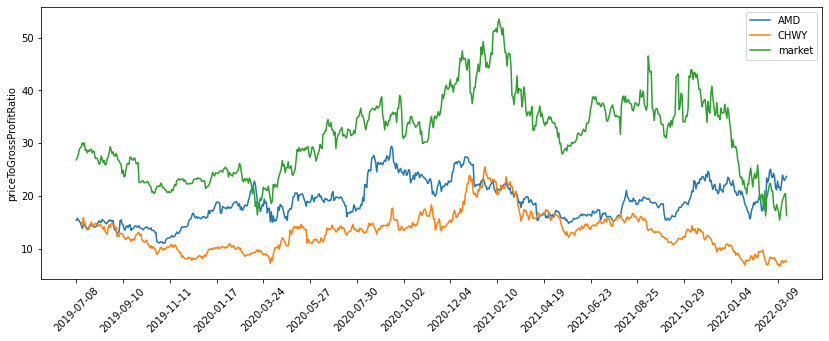

In [1450]:
kiwi.plot_metric_daily(['AMD', 'CHWY', 'market'], 'priceToGrossProfitRatio')

,tickers,priceToGrossProfitGrowthRatio_current,grossProfitGrowthTTM_current,priceToGrossProfitRatio_current,grossMargin_current,operatingMargin_current,operatingMargin_previous_1Y,ebitdaMargin_current,ebitdaMargin_previous_1Y,profitMargin_current,profitMargin_previous_1Y
36,market,0.285,65.225,20.32,48.94,-14.15,-16.36,NaN,0.48,-16.16,-16.25


In [1461]:
ranking = kiwi.summary[
    (kiwi.summary['operatingMargin_current'] > kiwi.summary['operatingMargin_previous_1Y'])
    & (kiwi.summary['operatingMargin_current'] > -10)
]

if "market" not in list(ranking['tickers']):
    ranking = pd.concat([ranking, kiwi.summary[kiwi.summary['tickers'] == "market"]])
    
ranking.sort_values('priceToGrossProfitGrowthRatio_current')

,tickers,priceToGrossProfitGrowthRatio_current,grossProfitGrowthTTM_current,priceToGrossProfitRatio_current,grossMargin_current,operatingMargin_current,operatingMargin_previous_1Y,ebitdaMargin_current,ebitdaMargin_previous_1Y,profitMargin_current,profitMargin_previous_1Y
4,BAND,0.090,38.430,3.54,44.51,-0.46,-1.41,NaN,2.53,-5.57,-7.11
18,PINS,0.120,64.780,8.02,79.47,12.65,11.11,NaN,9.90,12.27,10.99
11,MELI,0.270,75.820,20.47,42.51,6.23,6.07,NaN,9.13,1.18,0.84
36,market,0.285,65.225,20.32,48.94,-14.15,-16.36,NaN,0.48,-16.16,-16.25
1,AMD,0.290,82.400,23.67,48.25,22.20,20.69,NaN,22.36,19.24,22.88
13,NVDA,0.540,68.100,36.96,64.93,37.31,34.75,NaN,39.65,36.24,33.59
7,CRWD,0.720,65.670,47.50,73.60,-9.82,-10.18,NaN,-5.74,-16.16,-16.25
8,DDOG,0.850,67.880,57.89,77.23,-1.86,-3.40,NaN,1.24,-2.02,-4.19
34,UPST,NaN,NaN,inf,0.00,16.74,9.06,NaN,13.64,16.10,14.00


In [1302]:
from tqdm.notebook import tqdm

In [1443]:
class Kiwi:
    
    def __init__(self, tickers):
        self.tickers = tickers
        
        metrics = {}
        metrics_daily = {}
        stats = {}
        
        for ticker in tqdm(tickers):
            try:
                metrics[ticker], metrics_daily[ticker], stats[ticker] = stock_summary_data(ticker)
            except:
                continue
        
        metrics['market'] = metrics_market(metrics, "quarter")
        metrics_daily['market'] = metrics_market(metrics_daily, "date")
        stats['market'] = market_stats(stats)
        
        self.metrics = metrics
        self.metrics_daily = metrics_daily
        self.stats = stats
        
        self.summary = summary_stats(stats)
        
    
    def plot_metric(self, tickers, metric, years=10):
    
        quarters = years * 4

        max_length = max([len(self.metrics[ticker]) for ticker in tickers])
        filtr = min(40, max_length)

        lengths = {ticker: len(self.metrics[ticker]) for ticker in tickers}
        tickers_sorted = [ticker for ticker, length in sorted(lengths.items(), key=lambda item: item[1], reverse=True)]

        first_quarter = list(self.metrics[tickers_sorted[0]]['quarter'])[filtr]

        plt.figure(figsize=(14, 6))

        for ticker in tickers_sorted:

            filtr = self.metrics[ticker]['quarter'] >= first_quarter

            plt.plot(
                self.metrics[ticker][filtr]['quarter'][::-1],
                self.metrics[ticker][filtr][metric][::-1]
            )
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, quarters+1, 4))
        plt.legend(tickers_sorted)



    def plot_metric_daily(self, tickers, metric, limit=1500):

        plt.figure(figsize=(14, 5))

        limit = min(limit, min([len(self.metrics_daily[ticker]) for ticker in tickers]))
        
        dates = self.metrics_daily['market']['date'][:limit][::-1]

        for ticker in tickers:
            
            values = self.metrics_daily[ticker][metric][:limit][::-1]
            values = list(pd.Series(values).fillna(method='ffill'))
            
            plt.plot(dates, values)

        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, limit, limit // 15))

        plt.ylabel(metric)

        plt.legend(tickers);

In [1430]:
list(pd.Series([1, 2, 3, np.nan, 4, 5]).fillna(method='ffill'))

[1.0, 2.0, 3.0, 3.0, 4.0, 5.0]

In [743]:
summary_filtered = summary[
    (summary['operatingMargin_current'] > summary['operatingMargin_previous_1Y'])
    & (summary['priceToGrossProfitGrowthRatio_current'] < list(summary.loc[summary['tickers'] == 'market', 'priceToGrossProfitGrowthRatio_current'])[0])
]

pd.concat([summary_filtered, summary[summary['tickers'] == 'market']]).sort_values('priceToGrossProfitGrowthRatio_forecast')


,tickers,priceToGrossProfitGrowthRatio_forecast,priceToGrossProfitGrowthRatio_current,grossProfitGrowthTTM_current,grossProfitGrowthTTM_forecast,priceToGrossProfitRatio_current,grossMargin_current,operatingMargin_current,operatingMargin_previous_1Y,profitMargin_current,profitMargin_previous_1Y
15,PINS,0.16,0.35,22.34,29.5,7.84,79.47,12.65,-1.01,12.27,-0.46
25,TDOC,0.18,0.18,45.65,24.6,8.00,68.01,-14.15,-35.52,-21.09,-47.93
19,SE,0.22,0.15,147.49,47.5,21.91,37.58,-18.05,-25.51,-23.53,-32.43
8,MELI,0.24,0.27,74.46,35.2,19.89,42.51,6.23,5.28,1.18,-0.29
29,market,0.31,0.39,45.65,35.0,19.71,50.95,-9.82,-4.53,-6.67,-6.57
22,SMAR,0.32,0.33,45.42,33.3,14.96,78.86,-30.87,-31.17,-31.06,-29.79
7,ESTC,0.37,0.34,41.26,25.3,13.97,73.69,-18.88,-21.28,-22.67,-21.27
0,AMD,0.92,0.35,67.20,12.1,23.29,48.25,22.20,16.23,19.24,25.24


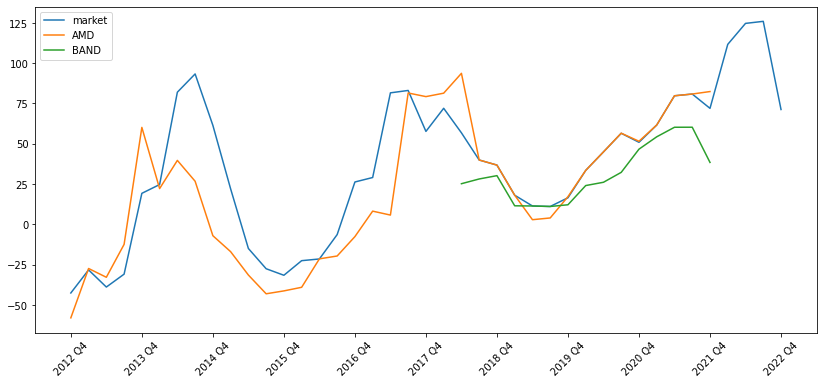

In [1239]:
plot_metric(metrics, ['BAND', 'AMD', 'market'], 'grossProfitGrowthTTM', years=10)

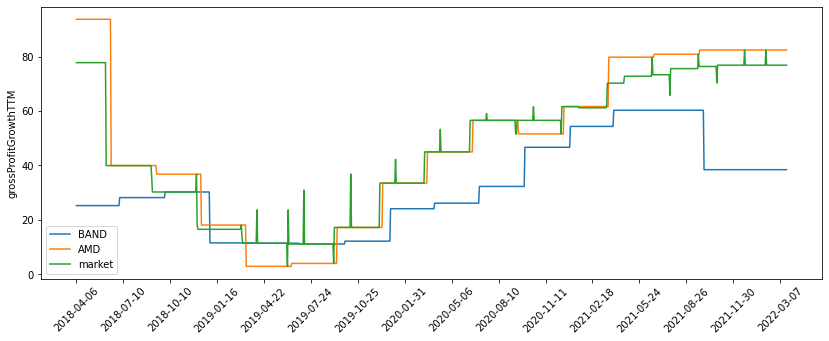

In [1224]:
plot_metric_daily(metrics_daily, ['BAND', 'AMD', 'market'], 'grossProfitGrowthTTM', limit=1000)